In [ ]:
#
import os
import json
import random
import nltk
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
#nltk.download('stopwords')
from collections import Counter

import threading
from tkinter import *
from tkinter import scrolledtext


In [ ]:
"""# load the dataset
with open('data/healthcare.json','r',encoding='utf-8') as f:
    data = json.load(f)

intents = {'intents':[]}
#
for convo in data:
    tag = convo.get("agent_selected_tool", "general").replace(" ","_").lower()


    pattern = convo.get("user_1", "")
    response = convo.get("agent_initial_response", "")


    if pattern and response:
        intents['intents'].append({
            "tag":tag,
            "patterns":[pattern],
            "responses":[response]
        })

# Save the new dataset
with open("data/healthcare_intents.json", "w", encoding="utf-8") as f:
    json.dump(intents, f, indent=4)


print('Dataset intentions create with sucess!')"""
    








In [ ]:
#
class ChatbotModel(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, 64)
        self.drop = nn.Dropout(0.4)
        self.out = nn.Linear(64, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.drop(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.drop(x)
        x = self.relu(self.bn3(self.fc3(x)))
        x = self.drop(x)
        x = self.relu(self.fc4(x))
        x = self.out(x)  
        return x


In [12]:
#
class ChatbotAssistant:
    def __init__(self, intents_path, function_mappings=None, device=None):
        self.intents_path = intents_path
        self.function_mappings = function_mappings

        self.documents = []              
        self.intents = []                
        self.intents_responses = {}      

        
        self.vectorizer = None
        self.label_names = None
        self.model = None

        
        self.X = None
        self.y = None

        
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")

    
    # 
    @staticmethod
    def preprocess_text(text):
        lemmatizer = WordNetLemmatizer()
        stop_words = set(stopwords.words('english'))
        if not isinstance(text, str):
            return ""
        tokens = nltk.word_tokenize(text.lower())
        tokens = [t for t in tokens if t.isalpha() and t not in stop_words]
        lemmas = [lemmatizer.lemmatize(t) for t in tokens]
        return " ".join(lemmas)

    
    
    # 
    def parse_intents(self):
        if not os.path.exists(self.intents_path):
            raise FileNotFoundError(f"File not found: {self.intents_path}")

        with open(self.intents_path, "r", encoding="utf-8") as f:
            data = json.load(f)

        self.documents = []
        self.intents = []
        self.intents_responses = {}

        for intent in data.get("intents", []):
            tag = intent.get("tag")
            if tag is None:
                continue
            if tag not in self.intents:
                self.intents.append(tag)
                self.intents_responses[tag] = intent.get("responses", [])

            for pattern in intent.get("patterns", []):
                cleaned = self.preprocess_text(pattern)
               
                self.documents.append((cleaned, tag))

        print(f"Loaded {len(self.documents)} patterns across {len(self.intents)} intents.")

    
    
    # 
    def build_features(self, max_features=2000):
        texts = [doc[0] for doc in self.documents]
        tags = [doc[1] for doc in self.documents]

        
        self.label_names = sorted(list(set(self.intents)))
        tag_to_idx = {t: i for i, t in enumerate(self.label_names)}
        self.y = np.array([tag_to_idx[t] for t in tags])

        
        self.vectorizer = TfidfVectorizer(max_features=max_features)
        X = self.vectorizer.fit_transform(texts).toarray()
        self.X = X
        print(f"TF-IDF built: X.shape = {self.X.shape}, y.shape = {self.y.shape}")

        cnt = Counter(self.y)
        valid = [cls for cls, c in cnt.items() if c >= 2]
        mask = np.isin(self.y, valid)
        self.X = self.X[mask]
        self.y = self.y[mask]
        print("Filtered shapes:", self.X.shape, self.y.shape)

        old_label_names = self.label_names
        new_label_names = [old_label_names[i] for i in valid]

        old_to_new = {old_idx: new_idx for new_idx, old_idx in enumerate(valid)}

        self.y = np.array([old_to_new[int(old)] for old in self.y if int(old) in old_to_new])

        self.label_names = new_label_names
        
        print(f"Nouvelle taille de label_names : {len(self.label_names)}")
   
    
    # 
    def train_model(self,
                    batch_size=32,
                    lr=1e-3,
                    epochs=50,
                    max_features=2000,
                    test_size=0.2,
                    scheduler_step=None,
                    scheduler_gamma=0.8,
                    random_state=42):
        
        if self.X is None or self.y is None:
            print("Building features (TF-IDF)...")
            self.build_features(max_features=max_features)

    # 
        cnt = Counter(self.y)
        valid = [cls for cls, c in cnt.items() if c >= 2]

        if len(valid) < 2:
            raise ValueError("Not enough valid classes with at least 2 samples each!")

        mask = np.isin(self.y, valid)
        self.X = self.X[mask]
        self.y = self.y[mask]

        print(f"Filtered dataset: {len(self.y)} samples, {len(valid)} valid classes")

    # 
        X_train, X_test, y_train, y_test = train_test_split(
            self.X, self.y, test_size=test_size, random_state=random_state,
            stratify=self.y if len(set(self.y)) > 1 else None
    )
        print(f"Train samples: {len(X_train)}, Test samples: {len(X_test)}")

        # 
        X_train_t = torch.tensor(X_train, dtype=torch.float32)
        y_train_t = torch.tensor(y_train, dtype=torch.long)
        X_test_t = torch.tensor(X_test, dtype=torch.float32)
        y_test_t = torch.tensor(y_test, dtype=torch.long)

        train_loader = DataLoader(TensorDataset(X_train_t, y_train_t),
                              batch_size=batch_size, shuffle=True)

    # 
        input_size = self.X.shape[1]
        output_size = len(valid)  

        self.model = ChatbotModel(input_size, output_size)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=lr)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step, gamma=scheduler_gamma)

        # 
        print("\n Starting training...\n")
        loss_values = []

        for epoch in range(epochs):
            self.model.train()
            running_loss = 0.0

            for batch_X, batch_y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
                optimizer.zero_grad()
                outputs = self.model(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            scheduler.step()
            epoch_loss = running_loss / len(train_loader)
            loss_values.append(epoch_loss)
            print(f"Epoch {epoch+1}/{epochs} | Loss: {epoch_loss:.4f} | LR: {scheduler.get_last_lr()[0]:.6f}")

        # 
        plt.figure(figsize=(8, 5))
        plt.plot(loss_values, label="Training Loss", color="blue")
        plt.title("Training Loss Curve")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)
        plt.show()

        # 
        self.model.eval()
        with torch.no_grad():
            preds = torch.argmax(self.model(X_test_t), dim=1).numpy()

        acc = accuracy_score(y_test, preds)
        print("\n=== Test set evaluation ===")
        print(f"Accuracy: {acc:.4f}")

    # 
        unique_labels = np.unique(y_test)
        filtered_names = [self.label_names[i] for i in unique_labels if i < len(self.label_names)]

        print(classification_report(
        y_test, preds,
        labels=unique_labels,
        target_names=filtered_names,
        zero_division=0
    ))

        print("\n Model training + evaluation complete.")

        # 
        print("Model training + evaluation complete.")
        unique_labels = np.unique(y_test)
        filtered_names = [self.label_names[i] for i in unique_labels]
    
    
    # 
    def save_all(self, model_path="chat_model.pth", meta_path="meta.pkl"):
        torch.save(self.model.state_dict(), model_path)
        meta = {
            "label_names": self.label_names,
            "vectorizer": self.vectorizer  
        }
        
        with open(meta_path, "wb") as f:
            pickle.dump(meta, f)
        print(f"Saved model to {model_path} and meta to {meta_path}.")

    def load_all(self, model_path="chat_model.pth", meta_path="meta.pkl"):
        with open(meta_path, "rb") as f:
            meta = pickle.load(f)
        self.label_names = meta["label_names"]
        self.vectorizer = meta["vectorizer"]
        input_size = self.vectorizer.max_features if hasattr(self.vectorizer, "max_features") and self.vectorizer.max_features is not None else self.vectorizer.vocabulary_.__len__()
        
        input_size = len(self.vectorizer.get_feature_names_out())
        output_size = len(self.label_names)
        self.model = ChatbotModel(input_size, output_size).to(self.device)
        self.model.load_state_dict(torch.load(model_path, map_location=self.device))
        self.model.eval()
        print(f"Loaded model and meta from {model_path}, {meta_path}.")

    
    
    # 
    def process_message(self, input_message, threshold=0.65, log_uncertain=True):
        if self.model is None or self.vectorizer is None:
            raise RuntimeError("Model or vectorizer not loaded. Call train_model() or load_all() first.")

        cleaned = self.preprocess_text(input_message)
        vec = self.vectorizer.transform([cleaned]).toarray()
        input_t = torch.tensor(vec, dtype=torch.float32).to(self.device)

        with torch.no_grad():
            logits = self.model(input_t)
            probs = F.softmax(logits, dim=1)
            confidence, idx = torch.max(probs, dim=1)
            confidence = confidence.item()
            pred_idx = idx.item()
            predicted_intent = self.label_names[pred_idx]

        if confidence >= threshold:
            
            resp = random.choice(self.intents_responses.get(predicted_intent, ["Sorry, I don't have a response."]))
            return f"({confidence*100:.1f}% confident) {resp}"
        else:
            if log_uncertain:
                with open("uncertain_inputs.log", "a", encoding="utf-8") as f:
                    f.write(input_message.strip() + "\n")
            return "I'm not sure I understood that. Could you rephrase?"



 


Loaded 758 patterns across 137 intents.
🔧 Building features (TF-IDF)...
TF-IDF built: X.shape = (758, 852), y.shape = (758,)
Filtered shapes: (690, 852) (690,)
Nouvelle taille de label_names : 69
Filtered dataset: 690 samples, 69 valid classes
Train samples: 552, Test samples: 138

🚀 Starting training...



Epoch 1/50 | Loss: 4.1347 | LR: 0.001000


Epoch 2/50 | Loss: 3.7100 | LR: 0.001000


Epoch 3/50 | Loss: 3.0996 | LR: 0.001000


Epoch 4/50 | Loss: 2.6856 | LR: 0.001000


Epoch 5/50 | Loss: 2.3039 | LR: 0.001000


Epoch 6/50 | Loss: 2.1153 | LR: 0.001000


Epoch 7/50 | Loss: 1.8933 | LR: 0.001000


Epoch 8/50 | Loss: 1.6653 | LR: 0.001000


Epoch 9/50 | Loss: 1.5059 | LR: 0.001000


Epoch 10/50 | Loss: 1.4091 | LR: 0.001000


Epoch 11/50 | Loss: 1.2823 | LR: 0.001000


Epoch 12/50 | Loss: 1.1228 | LR: 0.001000


Epoch 13/50 | Loss: 1.0567 | LR: 0.001000


Epoch 14/50 | Loss: 1.0369 | LR: 0.001000


Epoch 15/50 | Loss: 0.9482 | LR: 0.000800


Epoch 16/50 | Loss: 0.8850 | LR: 0.000800


Epoch 17/50 | Loss: 0.8231 | LR: 0.000800


Epoch 18/50 | Loss: 0.7523 | LR: 0.000800


Epoch 19/50 | Loss: 0.7103 | LR: 0.000800


Epoch 20/50 | Loss: 0.7530 | LR: 0.000800


Epoch 21/50 | Loss: 0.7069 | LR: 0.000800


Epoch 22/50 | Loss: 0.5935 | LR: 0.000800


Epoch 23/50 | Loss: 0.6344 | LR: 0.000800


Epoch 24/50 | Loss: 0.5053 | LR: 0.000800


Epoch 25/50 | Loss: 0.5422 | LR: 0.000800


Epoch 26/50 | Loss: 0.4540 | LR: 0.000800


Epoch 27/50 | Loss: 0.4321 | LR: 0.000800


Epoch 28/50 | Loss: 0.4375 | LR: 0.000800


Epoch 29/50 | Loss: 0.4002 | LR: 0.000800


Epoch 30/50 | Loss: 0.4119 | LR: 0.000640


Epoch 31/50 | Loss: 0.3349 | LR: 0.000640


Epoch 32/50 | Loss: 0.3286 | LR: 0.000640


Epoch 33/50 | Loss: 0.2720 | LR: 0.000640


Epoch 34/50 | Loss: 0.2685 | LR: 0.000640


Epoch 35/50 | Loss: 0.2901 | LR: 0.000640


Epoch 36/50 | Loss: 0.2774 | LR: 0.000640


Epoch 37/50 | Loss: 0.2539 | LR: 0.000640


Epoch 38/50 | Loss: 0.2605 | LR: 0.000640


Epoch 39/50 | Loss: 0.2531 | LR: 0.000640


Epoch 40/50 | Loss: 0.2276 | LR: 0.000640


Epoch 41/50 | Loss: 0.2703 | LR: 0.000640


Epoch 42/50 | Loss: 0.2486 | LR: 0.000640


Epoch 43/50 | Loss: 0.2355 | LR: 0.000640


Epoch 44/50 | Loss: 0.1957 | LR: 0.000640


Epoch 45/50 | Loss: 0.1983 | LR: 0.000512


Epoch 46/50 | Loss: 0.1991 | LR: 0.000512


Epoch 47/50 | Loss: 0.1648 | LR: 0.000512


Epoch 48/50 | Loss: 0.2130 | LR: 0.000512


Epoch 49/50 | Loss: 0.1608 | LR: 0.000512


Epoch 50/50 | Loss: 0.2085 | LR: 0.000512


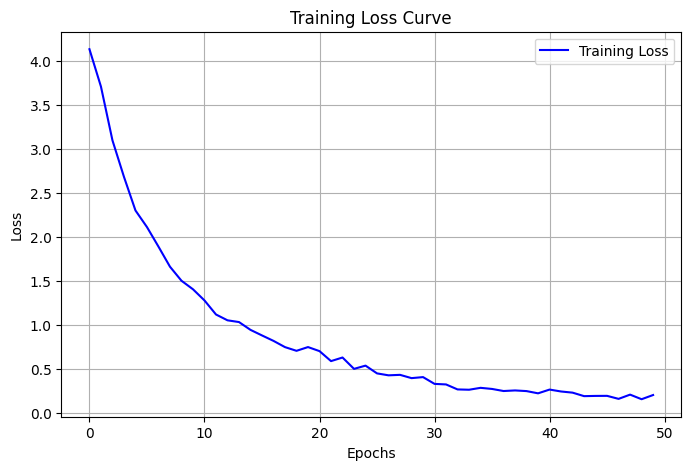


=== 🧪 Test set evaluation ===
Accuracy: 0.6449
                                    precision    recall  f1-score   support

                   bookappointment       0.20      0.20      0.20         5
             rescheduleappointment       0.80      0.89      0.84         9
                 cancelappointment       0.50      0.50      0.50         2
                  doctorinfolookup       0.60      0.60      0.60         5
                    billingsupport       0.89      1.00      0.94         8
                  emergencycontact       0.75      0.75      0.75         4
                      transfercall       0.00      0.00      0.00         4
                 checkreportstatus       0.89      1.00      0.94         8
                 updatepatientinfo       0.92      0.92      0.92        13
             insuranceclaimsupport       0.83      0.83      0.83         6
                    labtestbooking       1.00      0.67      0.80         3
                prescriptionrefill     

In [ ]:
#
"""if __name__ == "__main__":
    assistant = ChatbotAssistant("data/healthcare_intents.json")
    assistant.parse_intents()
    
    assistant.train_model(batch_size=32, lr=1e-3, epochs=50, max_features=2000, test_size=0.2, scheduler_step=15, scheduler_gamma=0.8)
    assistant.save_all("chat_model_tfidf.pth", "meta_tfidf.pkl")

    #assistant.load_all('chat_model_tfidf.pth','meta_tfidf.pkl')

     
    print("\nYou can chat. Type /quit to exit.")
    while True:
        msg = input("You: ")
        if msg.strip().lower() == "/quit":
            break
        print("Chatbot:", assistant.process_message(msg, threshold=0.65))"""

In [15]:


from __main__ import ChatbotAssistant

# 
BG_COLOR = "#1E1E1E"
BOT_COLOR = "#2D2D2D"
USER_COLOR = "#0078D7"
TEXT_COLOR = "#EAECEE"
INPUT_COLOR = "#2C2C2C"

FONT = "Helvetica 12"
FONT_BOLD = "Helvetica 12 bold"

BOT_NAME = "MedBot 🤖"

# 
class ModernChatApp:
    def __init__(self):
        self.window = Tk()
        self.window.title("MedBot - Healthcare Chat")
        self.window.configure(bg=BG_COLOR)
        self.window.geometry("500x600")
        self.window.resizable(False, False)

        self.setup_ui()

       
        self.assistant = ChatbotAssistant("data/healthcare_intents.json")
        self.assistant.parse_intents()

        
        if os.path.exists("chat_model_tfidf.pth") and os.path.exists("meta_tfidf.pkl"):
            self.assistant.load_all("chat_model_tfidf.pth", "meta_tfidf.pkl")
            print(" Model loaded successfully.")
        else:
            print("Model or metadata not found. Please train it first.")
            

    
    
    # 
    def setup_ui(self):
        # Header
        header = Label(self.window, text="💬 MedBot Healthcare Assistant",
                       bg=BG_COLOR, fg="#00A8E8", font=("Helvetica", 15, "bold"), pady=10)
        header.pack(fill=X)

        # Chat display (scrollable)
        self.chat_display = scrolledtext.ScrolledText(
            self.window, wrap=WORD, bg=BOT_COLOR, fg=TEXT_COLOR,
            font=FONT, padx=10, pady=10, state=DISABLED
        )
        self.chat_display.pack(padx=10, pady=10, fill=BOTH, expand=True)

        # Bottom frame (input + send button)
        bottom_frame = Frame(self.window, bg=BG_COLOR)
        bottom_frame.pack(fill=X, side=BOTTOM, pady=5)

        self.msg_entry = Entry(bottom_frame, bg=INPUT_COLOR, fg=TEXT_COLOR,
                               font=FONT, insertbackground=TEXT_COLOR, relief=FLAT)
        self.msg_entry.pack(fill=X, padx=10, pady=10, ipady=8, side=LEFT, expand=True)
        self.msg_entry.bind("<Return>", self.send_message)

        send_btn = Button(bottom_frame, text="Send ➤", bg="#00A8E8",
                          fg="white", font=FONT_BOLD, relief=FLAT,
                          command=lambda: self.send_message(None))
        send_btn.pack(side=RIGHT, padx=10, pady=5)

    
    
    # 
    def send_message(self, event):
        msg = self.msg_entry.get().strip()
        if not msg:
            return
        self.msg_entry.delete(0, END)

        self._insert_message(msg, sender="You", align="right", color=USER_COLOR)

        # Simulate typing
        self._insert_message("typing...", sender=BOT_NAME, align="left", color="#777777", temp=True)

        # Run bot response in a separate thread
        threading.Thread(target=self._get_bot_response, args=(msg,)).start()

    def _get_bot_response(self, msg):
        try:
            response = self.assistant.process_message(msg)
        except Exception as e:
            response = f" Error: {e}"

        # Remove "typing..."
        self._delete_last_line()
        self._insert_message(response, sender=BOT_NAME, align="left", color="#00A8E8")

    
    
    # 
    def _insert_message(self, text, sender, align="left", color="#00A8E8", temp=False):
        self.chat_display.configure(state=NORMAL)

        tag_name = f"{sender}_{align}_{color}"
        self.chat_display.tag_configure(tag_name, justify=align, foreground=color, spacing3=5)

        message = f"{sender}: {text}\n\n"
        self.chat_display.insert(END, message, tag_name)
        self.chat_display.configure(state=DISABLED)
        self.chat_display.see(END)

        # If it's temporary (like "typing..."), mark position
        if temp:
            self.last_temp_index = self.chat_display.index("end-2c")

    def _delete_last_line(self):
        """Remove temporary typing message"""
        self.chat_display.configure(state=NORMAL)
        self.chat_display.delete("end-3l", "end-1l")
        self.chat_display.configure(state=DISABLED)

    def run(self):
        self.window.mainloop()






In [16]:
#
if __name__ == "__main__":
    app = ModernChatApp()
    app.run()

Loaded 758 patterns across 137 intents.
Loaded model and meta from chat_model_tfidf.pth, meta_tfidf.pkl.
 Model loaded successfully.
